In [261]:
# Import Modules
# --------------
#
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

from discretize import TensorMesh
from discretize import TreeMesh
from discretize import base
from discretize.utils import mkvc, active_from_xyz, refine_tree_xyz
from SimPEG.utils import plot2Ddata, model_builder, mat_utils
from SimPEG import maps
from SimPEG.potential_fields import magnetics

In [262]:
[x_topo, y_topo] = np.meshgrid(np.linspace(-1500, 1500, 300), np.linspace(-1500, 1500, 250))
# z_topo = 250 * np.exp(-(x_topo**2 + y_topo**2) / 1000**2)

#Modelo de terreno 1
# z1 = 100 * np.sin((x_topo - 500) / 500) * np.sin((y_topo - 500) / 1000)
# z2 = 120 * np.sin((x_topo + 150) / 150) * np.sin((y_topo + 600) / 1000)

# Modelo de terreno 2
z1 = 50 * np.sin((x_topo - 500) / 500) * np.sin((y_topo - 200) / 1000)
z2 = 750 * np.sin((x_topo + 400) / 400) * np.sin((y_topo + 200) / 1000)

# Modelo de terreno 3
# z1 = 5 * np.sin((x_topo - 20) / 20) * np.sin((y_topo - 50) / 100)
# z2 = 75 * np.sin((x_topo + 40) / 40) * np.sin((y_topo + 50) / 100)

# Modelo de terreno 4
# z1 = 5 * np.sin((x_topo - 50) / 50) * np.sin((y_topo - 50) / 100)
# z2 = 75 * np.sin((x_topo + 50) / 50) * np.sin((y_topo + 50) / 100)

z_topo = z1 + z2

x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
xyz_topo = np.c_[x_topo, y_topo, z_topo]


In [263]:
#############################################
# Defining a Tensor Mesh
# ----------------------
#
# Here, we create the tensor mesh that will be used for the forward simulation.
#

# dh = 5.0
# hx = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
# hy = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
# hz = [(dh, 5, -1.3), (dh, 40)]
# mesh = TensorMesh([hx, hy, hz], "CCC")

# Defining a Tensor Mesh
# ----------------------
#
# Here, we create the tensor mesh that will be used for the forward simulation.
#

dh = 50.0

hx = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
hy = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
hz = [(dh, 5, -1.3), (dh, 30)]

mesh = TensorMesh([hx, hy, hz], "CCC")

# Now your mesh dimensions are scaled to kilometers


In [264]:
#Tamanho da área do levantamento

x = np.linspace(-1500.0,1500.0,30)
y = np.linspace(-1500.0, 1500.0,30)
x, y = np.meshgrid(x, y)
x, y = mkvc(x.T), mkvc(y.T)
fun_interp = LinearNDInterpolator(np.c_[x_topo, y_topo], z_topo)
z = fun_interp(np.c_[x, y]) + 100  # Flight height 100 m above surface.
receiver_locations = np.c_[x, y, z]

In [265]:
# Define the component(s) of the field we want to simulate as a list of strings.
# Here we simulation total magnetic intensity data.
components = ["bxz", "byz", "bzz"]

In [266]:
# Use the observation locations and components to define the receivers. To
# simulate data, the receivers must be defined as a list.
receiver_list = magnetics.receivers.Point(receiver_locations, components=components)

receiver_list = [receiver_list]

# Define the inducing field H0 = (intensity [nT], inclination [deg], declination [deg])
inclination = -11.6 # Inc Dec de carajás
declination = -20.4
strength = 50000
inducing_field = (strength, inclination, declination)

In [267]:
source_field = magnetics.sources.SourceField(
    receiver_list=receiver_list, parameters=inducing_field
)

# Define the survey
survey = magnetics.survey.Survey(source_field)

C:\Users\wende\AppData\Local\Temp\ipykernel_6284\719041710.py:1: FutureWarning: SourceField has been deprecated, please use UniformBackgroundField. It will be removed in version 0.19.0 of SimPEG.
  source_field = magnetics.sources.SourceField(


In [268]:
#############################################
# Defining a Susceptibility Model
# -------------------------------
#
# Here, we create the model that will be used to predict magnetic data
# and the mapping from the model to the mesh. The model
# consists of a susceptible sphere in a less susceptible host.
#

# Define susceptibility values for each unit in SI
background_susceptibility = 0.00001 #Alterei aqui!
sphere_susceptibility = 0.15 #Alterei aqui!
# sphere_susceptibility2 = 0.1
block_value = 0.098

# Find cells active in the forward modeling (cells below surface)
ind_active = active_from_xyz(mesh, xyz_topo)

# Define mapping from model to active cells
nC = int(ind_active.sum())
model_map = maps.IdentityMap(nP=3 * nC)  # model has 3 parameters for each cell
# Define susceptibility for each cell
susceptibility_model = background_susceptibility * np.ones(ind_active.sum())
ind_sphere = model_builder.get_indices_sphere(np.r_[0.0, 0.0, -250.0], 100.0, mesh.cell_centers ) #mesh.gridCC)
ind_sphere = ind_sphere[ind_active]
susceptibility_model[ind_sphere] = sphere_susceptibility

In [269]:
# Compute the unit direction of the inducing field in Cartesian coordinates
field_direction = mat_utils.dip_azimuth2cartesian(inclination, declination)

# Multiply susceptibility model to obtain the x, y, z components of the
# effective susceptibility contribution from induced magnetization.

susceptibility_model = np.outer(susceptibility_model, field_direction) # Qq coisa voltar aqui

# Define the effective susceptibility contribution for remanent magnetization to have a
# magnitude of 0.006 SI, with inclination -45 and declination 90
remanence_inclination = -45.0
remanence_declination = 90.0
remanence_susceptibility = 0.01

remanence_model = np.zeros(np.shape(susceptibility_model))
effective_susceptibility_sphere = (
    remanence_susceptibility
    * mat_utils.dip_azimuth2cartesian(remanence_inclination, remanence_declination)
)
remanence_model[ind_sphere, :] = effective_susceptibility_sphere


In [270]:
susceptibility_model1 = background_susceptibility * np.ones(ind_active.sum())

block_value = 0.18
ind_block = (
    (mesh.gridCC[ind_active, 0] > -600.0) # X
    & (mesh.gridCC[ind_active, 0] < -300.0) # X
    & (mesh.gridCC[ind_active, 1] > -300.0) # Y
    & (mesh.gridCC[ind_active, 1] < 300.0) # y
    & (mesh.gridCC[ind_active, 2] > -600.0) #Down Z
    & (mesh.gridCC[ind_active, 2] < -300.0) #Up Z
)
susceptibility_model1[ind_block] = block_value

In [271]:
# Compute the unit direction of the inducing field in Cartesian coordinates
field_direction = mat_utils.dip_azimuth2cartesian(inclination, declination)

# Multiply susceptibility model to obtain the x, y, z components of the
# effective susceptibility contribution from induced magnetization.

susceptibility_model1 = np.outer(susceptibility_model1, field_direction) # Qq coisa voltar aqui

# Define the effective susceptibility contribution for remanent magnetization to have a
# magnitude of 0.006 SI, with inclination -45 and declination 90
remanence1_inclination = -11.4
remanence1_declination = -20.6
remanence1_susceptibility = 0.097

remanence_model1 = np.zeros(np.shape(susceptibility_model1))
effective_susceptibility_block = (
    remanence1_susceptibility
    * mat_utils.dip_azimuth2cartesian(remanence1_inclination, remanence1_declination)
)
remanence_model1[ind_block, :] = effective_susceptibility_block

In [272]:
susceptibility_model2 = background_susceptibility * np.ones(ind_active.sum())
dyke_value = 0.19

xp = np.kron(np.ones((2)), [150.0, 300.0, 650.0, 450.0])
yp = np.kron([-80.0, 80.0], np.ones((4)))
zp = np.kron(np.ones((2)), [-600.0, -600.0, -150.0, -150.0])
xyz_pts = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
ind_polygon = model_builder.get_indices_polygon(mesh, xyz_pts)
ind_polygon = ind_polygon[ind_active]  # So same size and order as model
susceptibility_model2[ind_polygon] = dyke_value



In [273]:
# Compute the unit direction of the inducing field in Cartesian coordinates
field_direction = mat_utils.dip_azimuth2cartesian(inclination, declination)

# Multiply susceptibility model to obtain the x, y, z components of the
# effective susceptibility contribution from induced magnetization.

susceptibility_model2 = np.outer(susceptibility_model2, field_direction) # Qq coisa voltar aqui

# Define the effective susceptibility contribution for remanent magnetization to have a
# magnitude of 0.006 SI, with inclination -45 and declination 90
remanence2_inclination = -18.4
remanence2_declination = -21.6
remanence2_susceptibility = 0.09

remanence_model2 = np.zeros(np.shape(susceptibility_model2))
effective_susceptibility_dike = (
    remanence2_susceptibility
    * mat_utils.dip_azimuth2cartesian(remanence2_inclination, remanence2_declination)
)
remanence_model2[ind_block, :] = effective_susceptibility_dike

In [274]:
# Define effective susceptibility model as a vector np.r_[chi_x, chi_y, chi_z]
plotting_model = susceptibility_model + susceptibility_model1 + susceptibility_model2 +  remanence_model + remanence_model1 + remanence_model2
model = mkvc(plotting_model)

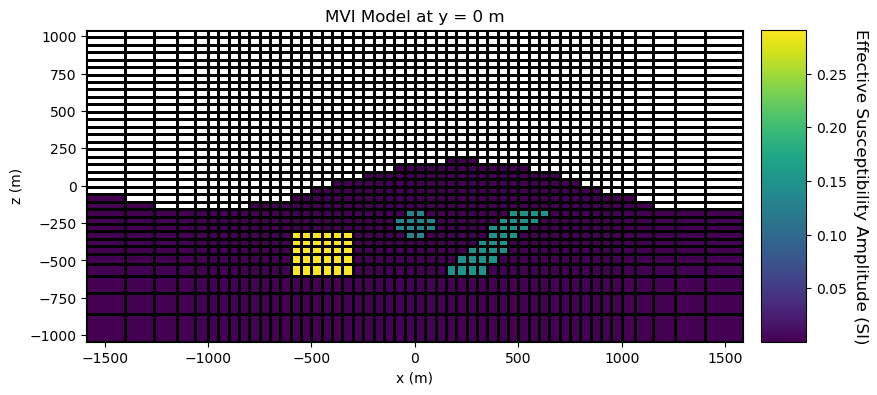

In [275]:
# fig = plt.figure(figsize=(9, 6))
# #Modelo gerado 
# plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
# ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
# mesh.plot_slice(
#     plotting_map * model,
#     normal="Y",
#     ax=ax1,
#     ind=int(mesh.shape_cells[1] / 2),
#     grid=True,
#     clim=(np.min(model), np.max(model)),
# )
# ax1.set_title("Model slice at y = 0 m")
# ax1.set_xlabel("x (m)")
# ax1.set_ylabel("z (m)")

# ax2 = fig.add_axes([0.85, 0.12, 0.05, 0.78])
# norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))
# cbar = mpl.colorbar.ColorbarBase(ax2, norm=norm, orientation="vertical")
# cbar.set_label("Magnetic Susceptibility (SI)", rotation=270, labelpad=15, size=12)

# Plot Effective Susceptibility Model
fig = plt.figure(figsize=(9, 4))

plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
plotting_model = np.sqrt(np.sum(plotting_model, axis=1) ** 2)
ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
mesh.plot_slice(
    plotting_map * plotting_model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.h[1].size / 2),
    grid=True,
    clim=(np.min(plotting_model), np.max(plotting_model)),
)
ax1.set_title("MVI Model at y = 0 m")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.85, 0.12, 0.05, 0.78])
norm = mpl.colors.Normalize(vmin=np.min(plotting_model), vmax=np.max(plotting_model))
cbar = mpl.colorbar.ColorbarBase(ax2, norm=norm, orientation="vertical")
cbar.set_label(
    "Effective Susceptibility Amplitude (SI)", rotation=270, labelpad=15, size=12
)

plt.show()

In [276]:
simulation = magnetics.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=mesh,
    model_type="vector",
    chiMap=model_map,
    ind_active=ind_active,
    store_sensitivities="forward_only",
)

# Compute predicted data for a susceptibility model
dpred = simulation.dpred(model)
n_data = len(dpred)

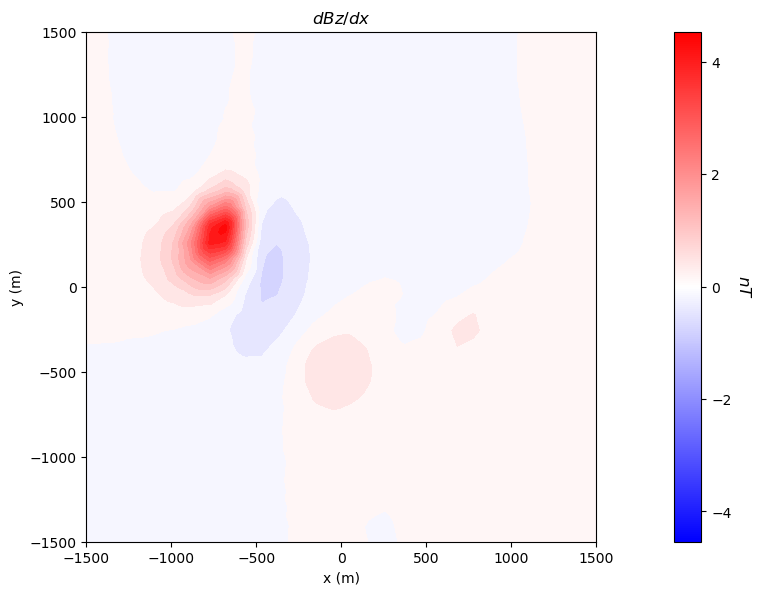

In [277]:
fig = plt.figure(figsize=(9, 6))
v_max = np.max(np.abs(dpred))

ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.85])
plot2Ddata(
    receiver_list[0].locations,
    dpred[0:n_data:3],
    ax=ax1,
    ncontour=30,
    clim=(-v_max, v_max),
    contourOpts={"cmap": "bwr"},
)

ax1.set_title("$dBz/dx$")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.87, 0.1, 0.03, 0.85])
norm = mpl.colors.Normalize(vmin=-np.max(np.abs(dpred)), vmax=np.max(np.abs(dpred)))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr
)
cbar.set_label("$nT$", rotation=270, labelpad=15, size=12)

plt.show()

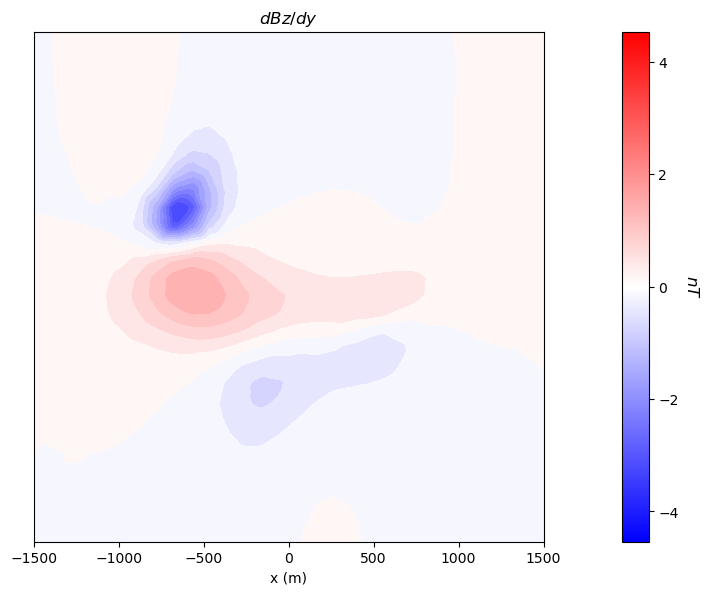

In [278]:
fig = plt.figure(figsize=(9, 6))
v_max = np.max(np.abs(dpred))

ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.85])

cplot2 = plot2Ddata(
    receiver_list[0].locations,
    dpred[1:n_data:3],
    ax=ax2,
    ncontour=30,
    clim=(-v_max, v_max),
    contourOpts={"cmap": "bwr"},
)
cplot2[0].set_clim((-v_max, v_max))
ax2.set_title("$dBz/dy$")
ax2.set_xlabel("x (m)")
ax2.set_yticks([])


ax3 = fig.add_axes([0.87, 0.1, 0.03, 0.85])
norm = mpl.colors.Normalize(vmin=-np.max(np.abs(dpred)), vmax=np.max(np.abs(dpred)))
cbar = mpl.colorbar.ColorbarBase(
    ax3, norm=norm, orientation="vertical", cmap=mpl.cm.bwr
)
cbar.set_label("$nT$", rotation=270, labelpad=15, size=12)

plt.show()

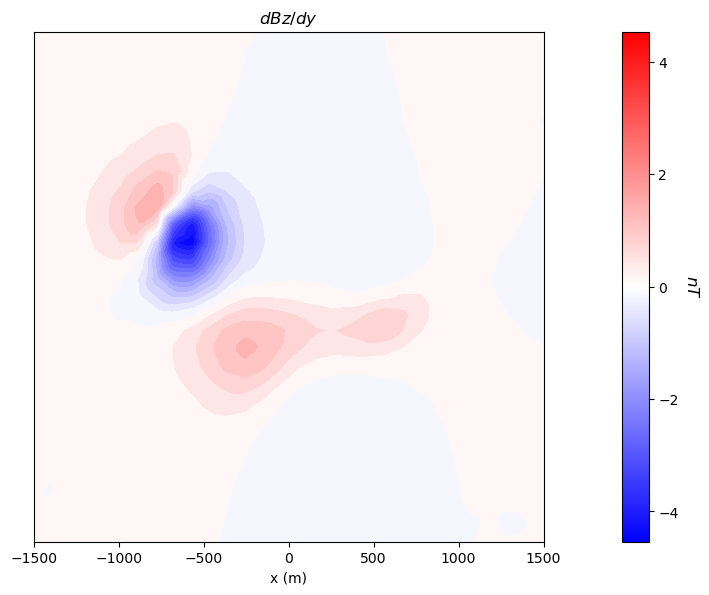

In [283]:
fig = plt.figure(figsize=(9, 6))
v_max = np.max(np.abs(dpred))

ax = fig.add_axes([0.1, 0.1, 0.8, 0.85])

cplot2 = plot2Ddata(
    receiver_list[0].locations,
    dpred[2:n_data:3],
    ax=ax,
    ncontour=30,
    clim=(-v_max, v_max),
    contourOpts={"cmap": "bwr"},
)

cplot2[0].set_clim((-v_max, v_max))
ax.set_title("$dBz/dy$")
ax.set_xlabel("x (m)")
ax.set_yticks([])

ax2 = fig.add_axes([0.87, 0.1, 0.03, 0.85])
norm = mpl.colors.Normalize(vmin=-np.max(np.abs(dpred)), vmax=np.max(np.abs(dpred)))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr
)
cbar.set_label("$nT$", rotation=270, labelpad=15, size=12)

plt.show()

In [280]:
write_output = False

if write_output:
    dir_path = os.path.dirname("E:\Mestrado UFPA (PESQUISA)\SIMPEG\simpeg-main\Modelagens_Mestrado").split(os.path.sep)
    dir_path.extend(["outputs2"])
    dir_path = os.path.sep.join(dir_path) + os.path.sep

    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

    fname = dir_path + "magnetics_topo_VII.XYZ"
    np.savetxt(fname, np.c_[xyz_topo], fmt="%.4e")

    np.random.seed(211)
    maximum_anomaly = np.max(np.abs(dpred))
    noise = 0.02 * maximum_anomaly * np.random.randn(len(dpred))
    fname = dir_path + "magnetics_data_VII.XYZ"
    np.savetxt(fname, np.c_[receiver_locations, dpred + noise], fmt="%.4e")